# Designing model for Optic Fiber Network fault detection, localization, and identification

## Data Handling

Imports:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import trange
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_curve, auc,
                             precision_recall_curve,
                             confusion_matrix, classification_report,
                             mean_squared_error)
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

Data Loading:

In [3]:
data_dir = "./data/OTDR_data.csv"
data = pd.read_csv(data_dir)

In [4]:
data.head()

Unnamed: 0        SNR        P1        P2        P3        P4        P5  \
0       70519  10.093627  0.989995  0.769634  0.866942  1.000000  0.838370   
1       81009   0.219347  0.341150  0.484929  0.689960  0.924820  0.648481   
2       62575   9.282432  0.438344  0.981339  0.728630  0.485106  0.359851   
3       70401   8.803449  0.674877  0.638932  0.651814  0.716335  0.475147   
4        7550  16.485467  0.767071  0.517559  0.115700  0.000000  0.055019   

         P6        P7        P8  ...       P25       P26       P27       P28  \
0  0.795462  0.801609  0.763259  ...  0.345600  0.114946  0.000000  0.381516   
1  0.196055  0.886128  1.000000  ...  0.384524  0.992029  0.488258  0.402361   
2  0.184697  0.222956  0.437243  ...  0.910126  0.964232  0.637623  0.162285   
3  0.628348  0.626998  0.691957  ...  0.411247  0.097255  0.210350  0.263302   
4  0.258061  0.115876  0.392273  ...  0.457824  0.864551  0.704364  0.508301   

        P29       P30  Class  Position  Reflectance   loss  
0  0.099061  0.280784    1.0      0.08          0.0  0.112  
1  0.321495  0.679280    3.0      0.11          0.0  0.400  
2  0.138643  0.723457    0.0      0.00          0.0  0.000  
3  0.132508  0.000000    1.0      0.09          0.0  0.100  
4  0.433237  0.028219    0.0      0.00          0.0  0.000  

[5 rows x 36 columns]

In [5]:
print(list(data.columns))

['Unnamed: 0', 'SNR', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'Class', 'Position', 'Reflectance', 'loss']


In [6]:
counts = (
    data['Class']
      .value_counts()
      .reindex(range(8), fill_value=0)
      .sort_index()
)

print(counts)

Class
0    16048
1    16000
2    16000
3    16000
4    16000
5    13849
6    16000
7    15935
Name: count, dtype: int64


Even class distribution, with 8 classes (0-7).

In [7]:
data.drop(columns=["Unnamed: 0"], inplace=True)

In [8]:
import hvplot.pandas
data.hvplot.scatter(x='SNR', y='Position', c='Class', cmap='coolwarm',
                    title='SNR vs Position by Class', width=800)

:Scatter   [SNR]   (Position,Class)

In [9]:
data.describe()

SNR             P1             P2             P3  \
count  125832.000000  125832.000000  125832.000000  125832.000000   
mean       12.315957       0.383666       0.379560       0.377179   
std         9.202129       0.343306       0.338766       0.336568   
min         0.000000       0.000000       0.000000       0.000000   
25%         3.000000       0.041760       0.038821       0.036689   
50%        13.000000       0.320210       0.315812       0.310499   
75%        20.106899       0.690142       0.685213       0.681227   
max        30.000000       1.000000       1.000000       1.000000   

                  P4             P5             P6             P7  \
count  125832.000000  125832.000000  125832.000000  125832.000000   
mean        0.375738       0.376254       0.382815       0.390346   
std         0.332489       0.326922       0.324796       0.319550   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.040424       0.051494       0.061802       0.079696   
50%         0.308350       0.313471       0.333092       0.351876   
75%         0.669226       0.660253       0.662213       0.658540   
max         1.000000       1.000000       1.000000       1.000000   

                  P8             P9  ...            P25            P26  \
count  125832.000000  125832.000000  ...  125832.000000  125832.000000   
mean        0.399960       0.412891  ...       0.476285       0.456533   
std         0.315327       0.312780  ...       0.296303       0.296518   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.090327       0.103174  ...       0.233595       0.215426   
50%         0.372897       0.397047  ...       0.441615       0.416618   
75%         0.664620       0.676426  ...       0.714035       0.683525   
max         1.000000       1.000000  ...       1.000000       1.000000   

                 P27            P28            P29            P30  \
count  125832.000000  125832.000000  125832.000000  125832.000000   
mean        0.437593       0.420615       0.402363       0.389017   
std         0.294765       0.293194       0.295106       0.306531   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.203007       0.192505       0.169732       0.144702   
50%         0.391529       0.366709       0.347401       0.332184   
75%         0.656642       0.635709       0.617000       0.609878   
max         1.000000       1.000000       1.000000       1.000000   

               Class       Position    Reflectance           loss  
count  125832.000000  125832.000000  125832.000000  125832.000000  
mean        3.471216       0.059272      -0.070685       0.222031  
std         2.302075       0.043066       0.092539       0.271161  
min         0.000000       0.000000      -0.300000       0.000000  
25%         1.000000       0.030000      -0.130000       0.000000  
50%         3.000000       0.060000       0.000000       0.092000  
75%         6.000000       0.090000       0.000000       0.400000  
max         7.000000       0.200000       0.000000       1.000000  

[8 rows x 35 columns]

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125832 entries, 0 to 125831
Data columns (total 35 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   SNR          125832 non-null  float64
 1   P1           125832 non-null  float64
 2   P2           125832 non-null  float64
 3   P3           125832 non-null  float64
 4   P4           125832 non-null  float64
 5   P5           125832 non-null  float64
 6   P6           125832 non-null  float64
 7   P7           125832 non-null  float64
 8   P8           125832 non-null  float64
 9   P9           125832 non-null  float64
 10  P10          125832 non-null  float64
 11  P11          125832 non-null  float64
 12  P12          125832 non-null  float64
 13  P13          125832 non-null  float64
 14  P14          125832 non-null  float64
 15  P15          125832 non-null  float64
 16  P16          125832 non-null  float64
 17  P17          125832 non-null  float64
 18  P18          125832 non-

In [11]:
data.isnull().sum()

SNR            0
P1             0
P2             0
P3             0
P4             0
P5             0
P6             0
P7             0
P8             0
P9             0
P10            0
P11            0
P12            0
P13            0
P14            0
P15            0
P16            0
P17            0
P18            0
P19            0
P20            0
P21            0
P22            0
P23            0
P24            0
P25            0
P26            0
P27            0
P28            0
P29            0
P30            0
Class          0
Position       0
Reflectance    0
loss           0
dtype: int64

No null values found in the dataset.

In [12]:
print(data.shape)

(125832, 35)


In [13]:
train, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Class'])

In [14]:
print(train.shape, test_data.shape)

(100665, 35) (25167, 35)


In [15]:
train_data, val_data = train_test_split(train, test_size=0.2, random_state=42, stratify=train['Class'])

In [16]:
print(train_data.shape, val_data.shape)

(80532, 35) (20133, 35)


In [17]:
print(test_data['Class'].value_counts().sort_index())

Class
0.0    3210
1.0    3200
2.0    3200
3.0    3200
4.0    3200
5.0    2770
6.0    3200
7.0    3187
Name: count, dtype: int64


In [18]:
print(train_data['Class'].value_counts().sort_index())

Class
0.0    10270
1.0    10240
2.0    10240
3.0    10240
4.0    10240
5.0     8863
6.0    10240
7.0    10199
Name: count, dtype: int64


In [19]:
print(val_data['Class'].value_counts().sort_index())

Class
0.0    2568
1.0    2560
2.0    2560
3.0    2560
4.0    2560
5.0    2216
6.0    2560
7.0    2549
Name: count, dtype: int64


### Setting up the data for training

In [20]:
measurement_cols = [c for c in data.columns if c.startswith('P')] + ['SNR']  # 30 points + SNR
X_train = train_data[measurement_cols].values.astype(np.float32)                          # (N, 31)
Y_train_class = train_data['Class'].astype(np.int64).values                        # categorical fault label
Y_train_position = train_data['Position'].astype(np.float32).values.reshape(-1, 1)

In [21]:
X_val = val_data[measurement_cols].values.astype(np.float32)                          # (N, 31)
Y_val_class = val_data['Class'].astype(np.int64).values                        # categorical fault label
Y_val_position = val_data['Position'].astype(np.float32).values.reshape(-1, 1)

In [22]:
X_test = test_data[measurement_cols].values.astype(np.float32)                          # (N, 31)
Y_test_class = test_data['Class'].astype(np.int64).values                        # categorical fault label
Y_test_position = test_data['Position'].astype(np.float32).values.reshape(-1, 1)

In [23]:
print(X_train.shape, Y_train_class.shape, Y_train_position.shape)

(80532, 32) (80532,) (80532, 1)


In [24]:
print(X_val.shape, Y_val_class.shape, Y_val_position.shape)

(20133, 32) (20133,) (20133, 1)


In [25]:
print(X_test.shape, Y_test_class.shape, Y_test_position.shape)

(25167, 32) (25167,) (25167, 1)


In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)     # fit ONLY on training data
X_val   = scaler.transform(X_val)           # transform validation
X_test  = scaler.transform(X_test)          # transform test

Making Tensors

In [27]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val,   dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test,  dtype=torch.float32)

y_class_train_tensor = torch.tensor(Y_train_class, dtype=torch.long)
y_class_val_tensor   = torch.tensor(Y_val_class,   dtype=torch.long)
y_class_test_tensor  = torch.tensor(Y_test_class,  dtype=torch.long)

y_pos_train_tensor = torch.tensor(Y_train_position, dtype=torch.float32)
y_pos_val_tensor   = torch.tensor(Y_val_position,   dtype=torch.float32)
y_pos_test_tensor  = torch.tensor(Y_test_position,  dtype=torch.float32)

## Model Functions

### GRU-AE

Checking CUDA:

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [29]:
print("PyTorch version:", torch.__version__)
print("Built with CUDA:", torch.version.cuda)
print("cuda.is_available():", torch.cuda.is_available())

PyTorch version: 2.5.1+cu121
Built with CUDA: 12.1
cuda.is_available(): True


Defining the GRU-AE and training it on normal traces:

In [30]:
NORMAL_LABEL = 0
idx_norm = (y_class_train_tensor == NORMAL_LABEL).nonzero(as_tuple=True)[0]

X_train_norm = X_train_tensor[idx_norm]           # shape (N_norm, 31)
train_loader_ae = DataLoader(X_train_norm, batch_size=256, shuffle=True, drop_last=True)

In [31]:
class VectorGRUAE(nn.Module):
    def __init__(self, feat_dim=31, hidden=128, latent=64, layers=3):
        super().__init__()
        self.encoder = nn.GRU(feat_dim, hidden, layers, batch_first=True, bidirectional=False)
        self.fc_mu  = nn.Linear(hidden, latent)
        self.fc_init= nn.Linear(latent, hidden*layers)
        self.decoder= nn.GRU(feat_dim, hidden, layers, batch_first=True)
        self.out    = nn.Linear(hidden, feat_dim)

    def forward(self, x):                # x (B, 1, 31)
        _, h_enc = self.encoder(x)
        z   = self.fc_mu(h_enc[-1])      # (B, latent)
        h0  = self.fc_init(z).view(self.decoder.num_layers, x.size(0), -1).contiguous()
        dec, _ = self.decoder(x, h0)
        return self.out(dec)

In [32]:
feat_dim = X_train_tensor.shape[1]
ae = VectorGRUAE(feat_dim=feat_dim, hidden=128, latent=64, layers=3).to(device)
opt = torch.optim.Adam(ae.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)

best_val, patience, PAT_MAX = 1e9, 0, 10
# training loop
for epoch in range(60):
    ae.train(); tr_loss = 0
    for xb in train_loader_ae:
        xb = xb.unsqueeze(1).to(device)           # (B,1,31)
        loss = loss_fn(ae(xb), xb)
        opt.zero_grad(); loss.backward(); opt.step()
        tr_loss += loss.item()*xb.size(0)

    # quick validation
    ae.eval()
    with torch.no_grad():
        samp = X_val_tensor[:5000].unsqueeze(1).to(device)
        val_loss = loss_fn(ae(samp), samp).item()

    print(f'E{epoch:02d}  trainMSE={tr_loss/len(train_loader_ae.dataset):.5f} ' f'valMSE={val_loss:.5f}')
    scheduler.step()

    if val_loss < best_val:
        best_val, patience = val_loss, 0
        torch.save(ae.state_dict(), 'models/gru_ae_deep.pt')
    else:
        patience += 1
        if patience == PAT_MAX:
            print('Early stopping'); break

E00  trainMSE=0.61360 valMSE=0.53166
E01  trainMSE=0.34993 valMSE=0.30143
E02  trainMSE=0.17169 valMSE=0.16877
E03  trainMSE=0.04659 valMSE=0.13344
E04  trainMSE=0.01093 valMSE=0.13263
E05  trainMSE=0.00752 valMSE=0.13537
E06  trainMSE=0.00643 valMSE=0.13855
E07  trainMSE=0.00564 valMSE=0.13923
E08  trainMSE=0.00503 valMSE=0.13907
E09  trainMSE=0.00453 valMSE=0.14145
E10  trainMSE=0.00406 valMSE=0.14038
E11  trainMSE=0.00382 valMSE=0.14173
E12  trainMSE=0.00364 valMSE=0.14199
E13  trainMSE=0.00348 valMSE=0.14343
E14  trainMSE=0.00331 valMSE=0.14437
Early stopping


Evaluating GRU-AE:

GRU-AE Threshold: 0.020


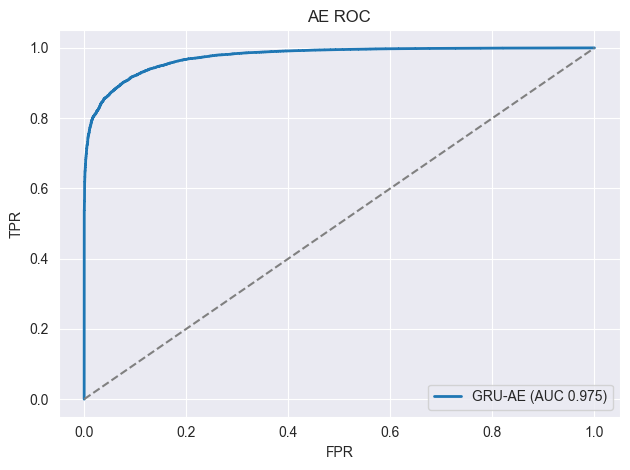

In [33]:
ae.load_state_dict(torch.load('models/gru_ae_deep.pt', map_location=device, weights_only=True))

def recon_err_vec(model, data, bs=512):
    model.eval(); errs=[]
    with torch.no_grad():
        for i in range(0, data.size(0), bs):
            x = data[i:i+bs].unsqueeze(1).to(device)
            errs.append(((model(x)-x)**2).mean(dim=(1,2)).cpu())
    return torch.cat(errs)

err_train = recon_err_vec(ae, X_train_norm)
threshold = torch.quantile(err_train, 0.94).item()
print(f'GRU-AE Threshold: {threshold:.3f}')

err_eval  = recon_err_vec(ae, torch.cat([X_val_tensor, X_test_tensor]))
y_eval    = (torch.cat([y_class_val_tensor, y_class_test_tensor]) != 0).numpy()

from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_eval, err_eval.numpy()); A = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'GRU-AE (AUC {A:.3f})')
plt.plot([0,1],[0,1],'--', c='grey'); plt.legend()
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('AE ROC'); plt.tight_layout()
plt.show()


Classification report:
               precision    recall  f1-score   support

      Normal       0.74      0.83      0.78      5778
     Anomaly       0.97      0.96      0.97     39522

    accuracy                           0.94     45300
   macro avg       0.86      0.89      0.87     45300
weighted avg       0.95      0.94      0.94     45300



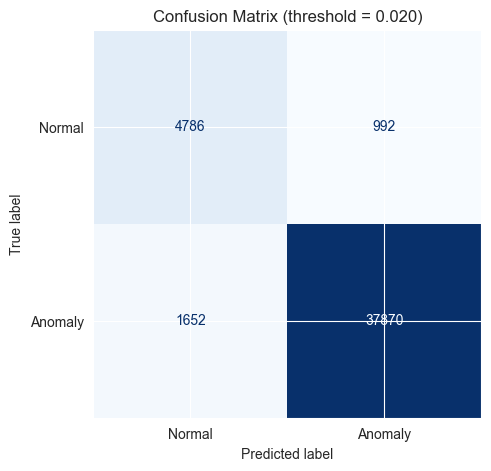

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = (err_eval.numpy() > threshold).astype(int)
y_true = y_eval.astype(int)

cm = confusion_matrix(y_true, y_pred)

print("\nClassification report:\n",
      classification_report(y_true, y_pred, target_names=['Normal','Anomaly']))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Normal','Anomaly'])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title(f'Confusion Matrix (threshold = {threshold:.3f})')
plt.tight_layout()
plt.show()


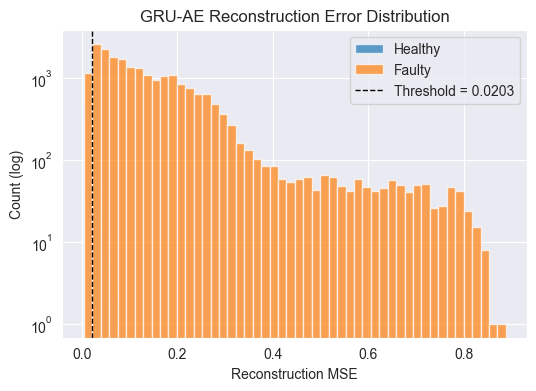

In [35]:
ae.eval()
test_ds  = TensorDataset(X_test_tensor,  y_class_test_tensor,  y_pos_test_tensor.squeeze(-1))
test_loader = DataLoader(test_ds, batch_size=256)
with torch.no_grad():
    recon_err = []
    for x in test_loader:
        x = x[0].to(device).unsqueeze(1)     # (B, 1, D)
        recon = ae(x)
        mse = (recon - x).pow(2).mean(dim=(1,2))  # per-sample error
        recon_err.append(mse.cpu())
recon_err = torch.cat(recon_err).numpy()

y_true_det = (y_class_test_tensor != NORMAL_LABEL).numpy().astype(int)  # 1 = fault, 0 = healthy
y_score_det = recon_err


plt.figure(figsize=(6,4))
plt.hist(recon_err[y_true_det==0], bins=50, alpha=0.7, label='Healthy')
plt.hist(recon_err[y_true_det==1], bins=50, alpha=0.7, label='Faulty')
plt.axvline(threshold, color='k', linestyle='--', linewidth=1,
            label=f'Threshold = {threshold:.4f}')
plt.yscale('log')
plt.xlabel('Reconstruction MSE'); plt.ylabel('Count (log)')
plt.title('GRU-AE Reconstruction Error Distribution')
plt.legend(); plt.show()


In [36]:
def reconstruction_errors_cond(batch_X, bs=512):
    amp_all, snr_all = batch_X[:, :30], batch_X[:, 30]
    errs = []
    ae.eval()
    with torch.no_grad():
        for i in range(0, batch_X.size(0), bs):
            amp = amp_all[i:i+bs].unsqueeze(-1).to(device)   # (B,30,1)
            snr = snr_all[i:i+bs].to(device)                # (B,)
            recon = ae(amp, snr)
            mse   = (recon - amp).pow(2).mean(dim=(1, 2))   # (B,)
            errs.append(mse.cpu())
    return torch.cat(errs)

def detect(batch_X, thresh=threshold):
    errs = reconstruction_errors_cond(batch_X)
    return errs > thresh

### TCN

TCN model definition:

In [37]:
class Chomp1d(nn.Module):
    def __init__(self, chomp):
        super().__init__(); self.chomp = chomp
    def forward(self, x):
        return x[:, :, :-self.chomp].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k, d):
        super().__init__()
        pad = (k - 1) * d
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, k, padding=pad, dilation=d),
            Chomp1d(pad), nn.ReLU(),
            nn.Conv1d(out_ch, out_ch, k, padding=pad, dilation=d),
            Chomp1d(pad), nn.ReLU()
        )
        self.down = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.net(x) + self.down(x))

class OTDR_TCN(nn.Module):
    def __init__(self, in_ch=1, mid_ch=64, n_blocks=5, k=3, n_classes=4):
        super().__init__()
        layers = []
        ch = in_ch
        for b in range(n_blocks):
            layers.append(TemporalBlock(ch, mid_ch, k, 2 ** b))
            ch = mid_ch
        self.tcn = nn.Sequential(*layers)
        self.gap = nn.AdaptiveAvgPool1d(1)      # global average over length

        # multitask heads
        self.class_head = nn.Linear(mid_ch, n_classes)
        self.loc_head   = nn.Linear(mid_ch, 1)

    def forward(self, x):            # x: (B, 1, L)
        h = self.tcn(x)
        h = self.gap(h).squeeze(-1)  # (B, mid_ch)
        return self.class_head(h), self.loc_head(h).squeeze(-1)

In [38]:
batch_size = 256

train_ds = TensorDataset(X_train_tensor, y_class_train_tensor, y_pos_train_tensor.squeeze(-1))
val_ds   = TensorDataset(X_val_tensor,   y_class_val_tensor,   y_pos_val_tensor.squeeze(-1))
test_ds  = TensorDataset(X_test_tensor,  y_class_test_tensor,  y_pos_test_tensor.squeeze(-1))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)

Training the TCN model:

In [39]:
n_fault_classes = int(y_class_train_tensor.max() + 1)

tcn = OTDR_TCN(in_ch=1,
               mid_ch=64,
               n_blocks=6,
               k=3,
               n_classes=n_fault_classes).to(device)

criterion_cls = nn.CrossEntropyLoss()
criterion_loc = nn.MSELoss()
lambda_loc = 0.5                              # scale for regression term

opt_tcn = torch.optim.Adam(tcn.parameters(), lr=1e-3)


In [40]:
num_epochs_tcn = 50
best_val_loss, patience, patience_max = float('inf'), 0, 10

for epoch in trange(num_epochs_tcn, desc='TCN'):
    # training loop
    tcn.train()
    t_loss = 0.
    for x, y_cls, y_loc in train_loader:
        x   = x.unsqueeze(1).to(device)         # (B, 1, L)
        y_c = y_cls.to(device)
        y_l = y_loc.to(device)

        logits, pred_loc = tcn(x)
        loss = criterion_cls(logits, y_c) + lambda_loc * criterion_loc(pred_loc, y_l)
        opt_tcn.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(tcn.parameters(), 1.0)
        opt_tcn.step()
        t_loss += loss.item() * x.size(0)

    # validation loop
    tcn.eval()
    v_loss, v_correct, v_samples, v_mse_sum = 0., 0, 0, 0.
    with torch.no_grad():
        for x, y_cls, y_loc in val_loader:
            x   = x.unsqueeze(1).to(device)
            y_c = y_cls.to(device)
            y_l = y_loc.to(device)

            logits, pred_loc = tcn(x)
            loss = criterion_cls(logits, y_c) + lambda_loc * criterion_loc(pred_loc, y_l)
            v_loss += loss.item() * x.size(0)

            v_correct += (logits.argmax(1) == y_c).sum().item()
            v_mse_sum += criterion_loc(pred_loc, y_l).item() * x.size(0)
            v_samples += x.size(0)

    v_loss /= v_samples
    v_acc  = v_correct / v_samples
    v_rmse = (v_mse_sum / v_samples) ** 0.5

    print(f'Epoch {epoch+1:02d} | train L={t_loss/len(train_ds):.4f} | '
          f'val L={v_loss:.4f} | val Acc={v_acc:.3f} | val RMSE={v_rmse:.3f}')

    # ---- early stopping ----
    if v_loss < best_val_loss:
        best_val_loss = v_loss
        torch.save(tcn.state_dict(), 'models/best_tcn.pt')
        patience = 0
    else:
        patience += 1
        if patience >= patience_max:
            print('Early stopping.')
            break


TCN:   2%|▏         | 1/50 [00:07<05:47,  7.10s/it]

Epoch 01 | train L=1.1314 | val L=0.9169 | val Acc=0.640 | val RMSE=0.066


TCN:   4%|▍         | 2/50 [00:12<04:38,  5.81s/it]

Epoch 02 | train L=0.8314 | val L=0.7786 | val Acc=0.707 | val RMSE=0.246


TCN:   6%|▌         | 3/50 [00:17<04:29,  5.74s/it]

Epoch 03 | train L=0.7193 | val L=0.6616 | val Acc=0.748 | val RMSE=0.087


TCN:   8%|▊         | 4/50 [00:22<04:14,  5.52s/it]

Epoch 04 | train L=0.5871 | val L=0.5277 | val Acc=0.812 | val RMSE=0.226


TCN:  10%|█         | 5/50 [00:27<03:58,  5.30s/it]

Epoch 05 | train L=0.4877 | val L=0.4336 | val Acc=0.844 | val RMSE=0.172


TCN:  12%|█▏        | 6/50 [00:32<03:37,  4.95s/it]

Epoch 06 | train L=0.4125 | val L=0.3807 | val Acc=0.857 | val RMSE=0.095


TCN:  14%|█▍        | 7/50 [00:36<03:23,  4.73s/it]

Epoch 07 | train L=0.3434 | val L=0.3015 | val Acc=0.893 | val RMSE=0.145


TCN:  16%|█▌        | 8/50 [00:40<03:14,  4.63s/it]

Epoch 08 | train L=0.2930 | val L=0.2782 | val Acc=0.910 | val RMSE=0.214


TCN:  18%|█▊        | 9/50 [00:45<03:05,  4.53s/it]

Epoch 09 | train L=0.2320 | val L=0.2603 | val Acc=0.911 | val RMSE=0.100


TCN:  20%|██        | 10/50 [00:49<03:00,  4.51s/it]

Epoch 10 | train L=0.2068 | val L=0.2336 | val Acc=0.916 | val RMSE=0.073


TCN:  22%|██▏       | 11/50 [00:53<02:52,  4.43s/it]

Epoch 11 | train L=0.1868 | val L=0.1795 | val Acc=0.930 | val RMSE=0.057


TCN:  24%|██▍       | 12/50 [00:58<02:47,  4.42s/it]

Epoch 12 | train L=0.1689 | val L=0.1486 | val Acc=0.945 | val RMSE=0.106


TCN:  26%|██▌       | 13/50 [01:02<02:42,  4.38s/it]

Epoch 13 | train L=0.1584 | val L=0.1934 | val Acc=0.930 | val RMSE=0.083


TCN:  28%|██▊       | 14/50 [01:06<02:36,  4.35s/it]

Epoch 14 | train L=0.1498 | val L=0.1502 | val Acc=0.942 | val RMSE=0.052


TCN:  30%|███       | 15/50 [01:11<02:32,  4.34s/it]

Epoch 15 | train L=0.1384 | val L=0.1405 | val Acc=0.946 | val RMSE=0.059


TCN:  32%|███▏      | 16/50 [01:15<02:28,  4.38s/it]

Epoch 16 | train L=0.1318 | val L=0.1373 | val Acc=0.948 | val RMSE=0.115


TCN:  34%|███▍      | 17/50 [01:19<02:22,  4.33s/it]

Epoch 17 | train L=0.1306 | val L=0.1327 | val Acc=0.950 | val RMSE=0.048


TCN:  36%|███▌      | 18/50 [01:23<02:17,  4.30s/it]

Epoch 18 | train L=0.1251 | val L=0.1613 | val Acc=0.941 | val RMSE=0.047


TCN:  38%|███▊      | 19/50 [01:28<02:12,  4.27s/it]

Epoch 19 | train L=0.1153 | val L=0.1287 | val Acc=0.953 | val RMSE=0.062


TCN:  40%|████      | 20/50 [01:32<02:08,  4.28s/it]

Epoch 20 | train L=0.1153 | val L=0.1391 | val Acc=0.948 | val RMSE=0.042


TCN:  42%|████▏     | 21/50 [01:36<02:03,  4.24s/it]

Epoch 21 | train L=0.1107 | val L=0.1291 | val Acc=0.952 | val RMSE=0.052


TCN:  44%|████▍     | 22/50 [01:40<01:59,  4.28s/it]

Epoch 22 | train L=0.1090 | val L=0.1365 | val Acc=0.949 | val RMSE=0.056


TCN:  46%|████▌     | 23/50 [01:45<01:55,  4.26s/it]

Epoch 23 | train L=0.1026 | val L=0.1199 | val Acc=0.957 | val RMSE=0.037


TCN:  48%|████▊     | 24/50 [01:49<01:50,  4.23s/it]

Epoch 24 | train L=0.0994 | val L=0.1182 | val Acc=0.956 | val RMSE=0.034


TCN:  50%|█████     | 25/50 [01:53<01:45,  4.21s/it]

Epoch 25 | train L=0.0930 | val L=0.1075 | val Acc=0.960 | val RMSE=0.057


TCN:  52%|█████▏    | 26/50 [01:57<01:40,  4.20s/it]

Epoch 26 | train L=0.0914 | val L=0.1109 | val Acc=0.961 | val RMSE=0.039


TCN:  54%|█████▍    | 27/50 [02:01<01:36,  4.18s/it]

Epoch 27 | train L=0.0840 | val L=0.1073 | val Acc=0.962 | val RMSE=0.035


TCN:  56%|█████▌    | 28/50 [02:05<01:31,  4.17s/it]

Epoch 28 | train L=0.0825 | val L=0.1161 | val Acc=0.960 | val RMSE=0.034


TCN:  58%|█████▊    | 29/50 [02:10<01:28,  4.22s/it]

Epoch 29 | train L=0.0782 | val L=0.1249 | val Acc=0.956 | val RMSE=0.037


TCN:  60%|██████    | 30/50 [02:14<01:23,  4.20s/it]

Epoch 30 | train L=0.0755 | val L=0.1346 | val Acc=0.956 | val RMSE=0.056


TCN:  62%|██████▏   | 31/50 [02:18<01:19,  4.18s/it]

Epoch 31 | train L=0.0744 | val L=0.1158 | val Acc=0.959 | val RMSE=0.072


TCN:  64%|██████▍   | 32/50 [02:22<01:15,  4.19s/it]

Epoch 32 | train L=0.0697 | val L=0.1134 | val Acc=0.962 | val RMSE=0.053


TCN:  66%|██████▌   | 33/50 [02:27<01:13,  4.30s/it]

Epoch 33 | train L=0.0633 | val L=0.1108 | val Acc=0.962 | val RMSE=0.035


TCN:  68%|██████▊   | 34/50 [02:31<01:09,  4.33s/it]

Epoch 34 | train L=0.0572 | val L=0.1287 | val Acc=0.957 | val RMSE=0.044


TCN:  70%|███████   | 35/50 [02:36<01:04,  4.32s/it]

Epoch 35 | train L=0.0615 | val L=0.1147 | val Acc=0.963 | val RMSE=0.061


TCN:  72%|███████▏  | 36/50 [02:40<00:59,  4.27s/it]

Epoch 36 | train L=0.0595 | val L=0.1068 | val Acc=0.965 | val RMSE=0.047


TCN:  74%|███████▍  | 37/50 [02:44<00:55,  4.25s/it]

Epoch 37 | train L=0.0536 | val L=0.1248 | val Acc=0.959 | val RMSE=0.038


TCN:  76%|███████▌  | 38/50 [02:48<00:50,  4.24s/it]

Epoch 38 | train L=0.0450 | val L=0.1085 | val Acc=0.965 | val RMSE=0.024


TCN:  78%|███████▊  | 39/50 [02:52<00:46,  4.27s/it]

Epoch 39 | train L=0.0350 | val L=0.1110 | val Acc=0.967 | val RMSE=0.070


TCN:  80%|████████  | 40/50 [02:57<00:43,  4.30s/it]

Epoch 40 | train L=0.0296 | val L=0.1295 | val Acc=0.965 | val RMSE=0.050


TCN:  82%|████████▏ | 41/50 [03:01<00:39,  4.38s/it]

Epoch 41 | train L=0.0454 | val L=0.1091 | val Acc=0.968 | val RMSE=0.082


TCN:  84%|████████▍ | 42/50 [03:06<00:34,  4.36s/it]

Epoch 42 | train L=0.0275 | val L=0.1544 | val Acc=0.956 | val RMSE=0.048


TCN:  86%|████████▌ | 43/50 [03:10<00:30,  4.33s/it]

Epoch 43 | train L=0.0541 | val L=0.1225 | val Acc=0.965 | val RMSE=0.032


TCN:  88%|████████▊ | 44/50 [03:14<00:25,  4.33s/it]

Epoch 44 | train L=0.0396 | val L=0.1345 | val Acc=0.961 | val RMSE=0.045


TCN:  90%|█████████ | 45/50 [03:19<00:21,  4.32s/it]

Epoch 45 | train L=0.0426 | val L=0.1260 | val Acc=0.965 | val RMSE=0.048


TCN:  90%|█████████ | 45/50 [03:23<00:22,  4.53s/it]

Epoch 46 | train L=0.0276 | val L=0.1187 | val Acc=0.965 | val RMSE=0.034
Early stopping.


Evaluating the TCN model on the test set:

In [41]:
tcn.load_state_dict(torch.load('models/best_tcn.pt', map_location=device, weights_only=True))
tcn.eval()

test_loader = DataLoader(test_ds, batch_size=batch_size)

test_correct, test_samples, test_mse_sum = 0, 0, 0.
with torch.no_grad():
    for x, y_cls, y_loc in test_loader:
        x   = x.unsqueeze(1).to(device)
        y_c = y_cls.to(device)
        y_l = y_loc.to(device)

        logits, pred_loc = tcn(x)
        test_correct += (logits.argmax(1) == y_c).sum().item()
        test_mse_sum  += criterion_loc(pred_loc, y_l).item() * x.size(0)
        test_samples  += x.size(0)

test_acc  = test_correct / test_samples
test_rmse = (test_mse_sum / test_samples) ** 0.5
print(f'Test Acc = {test_acc:.3f} | Test RMSE = {test_rmse:.3f}')


Test Acc = 0.965 | Test RMSE = 0.047


## Evaluation

TCN Evaluation:

In [42]:
tcn.eval()
all_preds_cls, all_true_cls = [], []
all_preds_loc, all_true_loc = [], []

with torch.no_grad():
    for x, y_cls, y_loc in test_loader:
        x = x.unsqueeze(1).to(device)
        logits, pred_loc = tcn(x)
        all_preds_cls.append(logits.argmax(1).cpu())
        all_preds_loc.append(pred_loc.cpu())
        all_true_cls.append(y_cls)
        all_true_loc.append(y_loc)

all_preds_cls = torch.cat(all_preds_cls).numpy()
all_true_cls  = torch.cat(all_true_cls ).numpy()
all_preds_loc = torch.cat(all_preds_loc).numpy()
all_true_loc  = torch.cat(all_true_loc ).numpy()


              precision    recall  f1-score   support

           0      0.999     0.998     0.998      3210
           1      0.994     0.992     0.993      3200
           2      0.988     0.974     0.981      3200
           3      0.930     0.958     0.944      3200
           4      0.983     0.973     0.978      3200
           5      0.864     0.916     0.889      2770
           6      0.969     0.914     0.941      3200
           7      0.983     0.986     0.985      3187

    accuracy                          0.965     25167
   macro avg      0.964     0.964     0.964     25167
weighted avg      0.965     0.965     0.965     25167



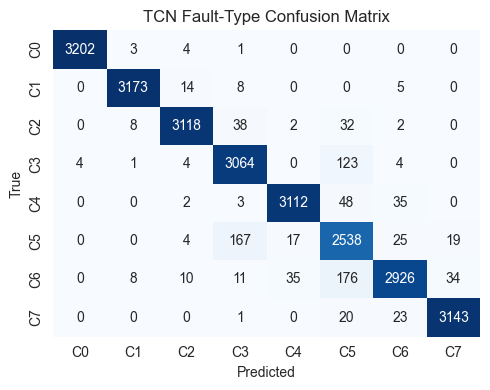

In [43]:
cm = confusion_matrix(all_true_cls, all_preds_cls)
class_report = classification_report(all_true_cls, all_preds_cls, digits=3)
print(class_report)

plt.figure(figsize=(5,4))
sns.heatmap(cm,
            annot=True, fmt='d',
            cmap='Blues',
            cbar=False,
            xticklabels=[f'C{i}' for i in range(cm.shape[0])],
            yticklabels=[f'C{i}' for i in range(cm.shape[0])])
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('TCN Fault-Type Confusion Matrix'); plt.tight_layout(); plt.show()


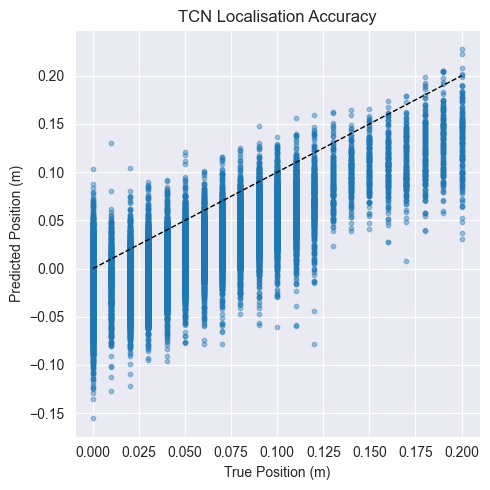

In [44]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seq_len = X_test_tensor.shape[1]           # 31
n_classes = 8                              # healthy + 7 faults
tcn = OTDR_TCN(in_ch=1,
               mid_ch=64,
               n_blocks=6,
               k=3,
               n_classes=n_classes).to(device)
tcn.load_state_dict(torch.load('models/best_tcn.pt', map_location=device, weights_only=True))
tcn.eval()

test_loader = DataLoader(
    TensorDataset(X_test_tensor, y_pos_test_tensor.squeeze(-1)),
    batch_size=256
)

all_preds_loc, all_true_loc = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        # TCN expects (B, 1, L)
        _, loc_hat = tcn(xb.unsqueeze(1).to(device))
        all_preds_loc.append(loc_hat.cpu())
        all_true_loc.append(yb)

all_preds_loc = torch.cat(all_preds_loc).numpy()
all_true_loc  = torch.cat(all_true_loc).numpy()


plt.figure(figsize=(5, 5))
plt.scatter(all_true_loc, all_preds_loc, alpha=0.4, s=10)
lims = [all_true_loc.min(), all_true_loc.max()]
plt.plot(lims, lims, 'k--', linewidth=1)
plt.xlabel('True Position (m)')
plt.ylabel('Predicted Position (m)')
plt.title('TCN Localisation Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()


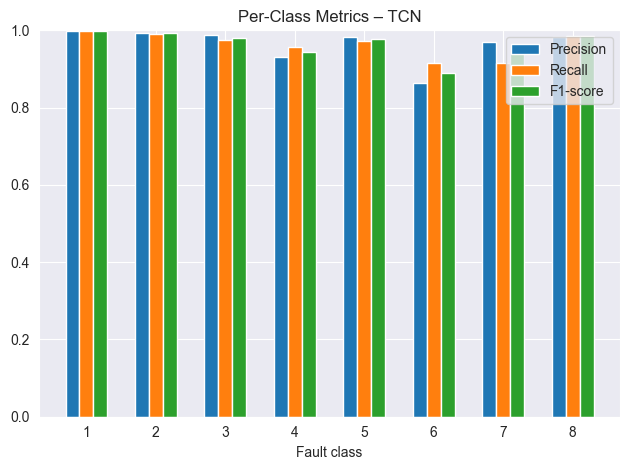

In [45]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support


# bar chart of precision, recall, F1
prec, rec, f1, _ = precision_recall_fscore_support(all_true_cls, all_preds_cls, zero_division=0)
x = np.arange(n_fault_classes)

plt.figure()
plt.bar(x-0.2, prec, width=0.2, label='Precision')
plt.bar(x,     rec,  width=0.2, label='Recall')
plt.bar(x+0.2, f1,   width=0.2, label='F1-score')
plt.xticks(x, x+1)
plt.xlabel('Fault class')
plt.ylim(0, 1)
plt.title('Per-Class Metrics – TCN')
plt.legend()
plt.tight_layout()
plt.show()


## Time Series Transformer Model

In [46]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, seq_len=31, d_model=128, n_heads=4, n_layers=4,
                 dim_feedforward=256, dropout=0.1, n_classes=4):
        super().__init__()
        self.seq_len = seq_len
        # scalar amplitude → d_model
        self.input_proj = nn.Linear(1, d_model)

        # learnable positional encodings
        self.pos_embed = nn.Parameter(torch.randn(seq_len, d_model))

        # vanilla encoder stack
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model,
                                               nhead=n_heads,
                                               dim_feedforward=dim_feedforward,
                                               dropout=dropout,
                                               batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)

        # task heads
        self.cls_head = nn.Linear(d_model, n_classes)
        self.loc_head = nn.Linear(d_model, 1)

        # initialisation (Xavier)
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv1d)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        if x.dim() == 3:           # (B, 1, L)
            x = x.squeeze(1)
        B, L = x.shape             # expect L == seq_len
        x = x.unsqueeze(-1)        # (B, L, 1)
        h = self.input_proj(x)     # (B, L, d_model)
        h = h + self.pos_embed[None, :, :]  # add positional enc.

        h = self.encoder(h)        # (B, L, d_model)
        h = h.mean(dim=1)          # global average pooling

        return self.cls_head(h), self.loc_head(h).squeeze(-1)


Transformer training:

In [47]:
seq_len        = X_train_tensor.shape[1]          # 31
n_fault_classes = int(y_class_train_tensor.max() + 1)

tst = TimeSeriesTransformer(seq_len=seq_len,
                            d_model=128,
                            n_heads=4,
                            n_layers=4,
                            dim_feedforward=256,
                            dropout=0.1,
                            n_classes=n_fault_classes).to(device)

criterion_cls = nn.CrossEntropyLoss()
criterion_loc = nn.MSELoss()
lambda_loc    = 0.5                     # weight for regression term

opt_tst = torch.optim.AdamW(tst.parameters(), lr=2e-4, weight_decay=1e-2)

sch_tst = torch.optim.lr_scheduler.StepLR(opt_tst, step_size=15, gamma=0.5)


In [48]:
n_epochs_tst   = 60
best_val_loss  = float('inf')
patience, pat_max = 0, 10

for epoch in trange(n_epochs_tst, desc='TST'):
    # training loop
    tst.train()
    tr_loss = 0.
    for x, y_cls, y_loc in train_loader:
        x   = x.to(device)
        y_c = y_cls.to(device)
        y_l = y_loc.to(device)

        logits, p_loc = tst(x)
        loss = criterion_cls(logits, y_c) + lambda_loc * criterion_loc(p_loc, y_l)

        opt_tst.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(tst.parameters(), 1.0)
        opt_tst.step()
        tr_loss += loss.item() * x.size(0)

    # validation
    tst.eval()
    val_loss, val_corr, val_samp, val_mse = 0., 0, 0, 0.
    with torch.no_grad():
        for x, y_cls, y_loc in val_loader:
            x, y_c, y_l = x.to(device), y_cls.to(device), y_loc.to(device)
            logits, p_loc = tst(x)
            loss = criterion_cls(logits, y_c) + lambda_loc * criterion_loc(p_loc, y_l)

            val_loss += loss.item() * x.size(0)
            val_corr += (logits.argmax(1) == y_c).sum().item()
            val_mse  += criterion_loc(p_loc, y_l).item() * x.size(0)
            val_samp += x.size(0)

    val_loss /= val_samp
    val_acc   = val_corr / val_samp
    val_rmse  = (val_mse / val_samp) ** 0.5

    print(f'Epoch {epoch+1:02d} | trL={tr_loss/len(train_ds):.4f} | '
          f'valL={val_loss:.4f} | valAcc={val_acc:.3f} | valRMSE={val_rmse:.3f}')

    sch_tst.step()
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(tst.state_dict(), 'models/best_tst.pt')
        patience = 0
    else:
        patience += 1
        if patience >= pat_max:
            print('Early stopping.')
            break


TST:   2%|▏         | 1/60 [00:05<05:33,  5.65s/it]

Epoch 01 | trL=0.9372 | valL=0.2961 | valAcc=0.891 | valRMSE=0.073


TST:   3%|▎         | 2/60 [00:11<05:18,  5.50s/it]

Epoch 02 | trL=0.2892 | valL=0.1910 | valAcc=0.932 | valRMSE=0.045


TST:   5%|▌         | 3/60 [00:16<05:10,  5.46s/it]

Epoch 03 | trL=0.2071 | valL=0.1528 | valAcc=0.943 | valRMSE=0.046


TST:   7%|▋         | 4/60 [00:21<05:04,  5.44s/it]

Epoch 04 | trL=0.1827 | valL=0.1481 | valAcc=0.942 | valRMSE=0.036


TST:   8%|▊         | 5/60 [00:27<05:00,  5.46s/it]

Epoch 05 | trL=0.1649 | valL=0.1485 | valAcc=0.942 | valRMSE=0.032


TST:  10%|█         | 6/60 [00:33<04:59,  5.55s/it]

Epoch 06 | trL=0.1563 | valL=0.1271 | valAcc=0.949 | valRMSE=0.028


TST:  12%|█▏        | 7/60 [00:38<04:51,  5.50s/it]

Epoch 07 | trL=0.1499 | valL=0.1312 | valAcc=0.949 | valRMSE=0.026


TST:  13%|█▎        | 8/60 [00:43<04:44,  5.48s/it]

Epoch 08 | trL=0.1420 | valL=0.1213 | valAcc=0.950 | valRMSE=0.024


TST:  15%|█▌        | 9/60 [00:49<04:38,  5.47s/it]

Epoch 09 | trL=0.1366 | valL=0.1283 | valAcc=0.951 | valRMSE=0.024


TST:  17%|█▋        | 10/60 [00:54<04:32,  5.44s/it]

Epoch 10 | trL=0.1324 | valL=0.1128 | valAcc=0.954 | valRMSE=0.019


TST:  18%|█▊        | 11/60 [01:00<04:26,  5.43s/it]

Epoch 11 | trL=0.1316 | valL=0.1113 | valAcc=0.955 | valRMSE=0.020


TST:  20%|██        | 12/60 [01:06<04:27,  5.58s/it]

Epoch 12 | trL=0.1290 | valL=0.1227 | valAcc=0.952 | valRMSE=0.018


TST:  22%|██▏       | 13/60 [01:11<04:23,  5.60s/it]

Epoch 13 | trL=0.1250 | valL=0.1253 | valAcc=0.952 | valRMSE=0.017


TST:  23%|██▎       | 14/60 [01:17<04:14,  5.53s/it]

Epoch 14 | trL=0.1242 | valL=0.1164 | valAcc=0.953 | valRMSE=0.020


TST:  25%|██▌       | 15/60 [01:22<04:06,  5.48s/it]

Epoch 15 | trL=0.1224 | valL=0.1141 | valAcc=0.954 | valRMSE=0.017


TST:  27%|██▋       | 16/60 [01:27<03:59,  5.44s/it]

Epoch 16 | trL=0.1123 | valL=0.1145 | valAcc=0.956 | valRMSE=0.015


TST:  28%|██▊       | 17/60 [01:33<03:54,  5.46s/it]

Epoch 17 | trL=0.1109 | valL=0.1074 | valAcc=0.958 | valRMSE=0.016


TST:  30%|███       | 18/60 [01:38<03:49,  5.46s/it]

Epoch 18 | trL=0.1091 | valL=0.1073 | valAcc=0.959 | valRMSE=0.016


TST:  32%|███▏      | 19/60 [01:44<03:44,  5.47s/it]

Epoch 19 | trL=0.1069 | valL=0.1050 | valAcc=0.959 | valRMSE=0.013


TST:  33%|███▎      | 20/60 [01:49<03:37,  5.44s/it]

Epoch 20 | trL=0.1067 | valL=0.1028 | valAcc=0.960 | valRMSE=0.014


TST:  35%|███▌      | 21/60 [01:55<03:31,  5.43s/it]

Epoch 21 | trL=0.1064 | valL=0.1040 | valAcc=0.959 | valRMSE=0.016


TST:  37%|███▋      | 22/60 [02:00<03:26,  5.43s/it]

Epoch 22 | trL=0.1072 | valL=0.1039 | valAcc=0.959 | valRMSE=0.013


TST:  38%|███▊      | 23/60 [02:05<03:21,  5.46s/it]

Epoch 23 | trL=0.1049 | valL=0.1088 | valAcc=0.958 | valRMSE=0.012


TST:  40%|████      | 24/60 [02:11<03:15,  5.43s/it]

Epoch 24 | trL=0.1036 | valL=0.1100 | valAcc=0.958 | valRMSE=0.013


TST:  42%|████▏     | 25/60 [02:16<03:11,  5.47s/it]

Epoch 25 | trL=0.1042 | valL=0.1072 | valAcc=0.959 | valRMSE=0.014


TST:  43%|████▎     | 26/60 [02:22<03:05,  5.44s/it]

Epoch 26 | trL=0.1025 | valL=0.1093 | valAcc=0.960 | valRMSE=0.013


TST:  45%|████▌     | 27/60 [02:27<02:58,  5.42s/it]

Epoch 27 | trL=0.1015 | valL=0.1080 | valAcc=0.959 | valRMSE=0.013


TST:  47%|████▋     | 28/60 [02:33<02:53,  5.42s/it]

Epoch 28 | trL=0.1023 | valL=0.1048 | valAcc=0.959 | valRMSE=0.012


TST:  48%|████▊     | 29/60 [02:38<02:47,  5.40s/it]

Epoch 29 | trL=0.1002 | valL=0.1201 | valAcc=0.955 | valRMSE=0.012


TST:  48%|████▊     | 29/60 [02:43<02:55,  5.65s/it]

Epoch 30 | trL=0.1015 | valL=0.1038 | valAcc=0.959 | valRMSE=0.013
Early stopping.


Transformer Evaluation:

In [49]:
tst.load_state_dict(torch.load('models/best_tst.pt', map_location=device, weights_only=True))
tst.eval()

test_loader = DataLoader(test_ds, batch_size=256)

test_corr, test_samp, test_mse = 0, 0, 0.
with torch.no_grad():
    for x, y_cls, y_loc in test_loader:
        x, y_c, y_l = x.to(device), y_cls.to(device), y_loc.to(device)
        logits, p_loc = tst(x)

        test_corr += (logits.argmax(1) == y_c).sum().item()
        test_mse  += criterion_loc(p_loc, y_l).item() * x.size(0)
        test_samp += x.size(0)

test_acc  = test_corr / test_samp
test_rmse = (test_mse / test_samp) ** 0.5
print(f'Transformer – Test Acc = {test_acc:.3f} | Test RMSE = {test_rmse:.3f}')


Transformer – Test Acc = 0.960 | Test RMSE = 0.014


              precision    recall  f1-score   support

           0      1.000     1.000     1.000      3210
           1      0.997     0.992     0.995      3200
           2      0.996     0.978     0.987      3200
           3      0.927     0.927     0.927      3200
           4      0.988     0.979     0.983      3200
           5      0.825     0.890     0.856      2770
           6      0.959     0.913     0.936      3200
           7      0.983     0.995     0.989      3187

    accuracy                          0.960     25167
   macro avg      0.959     0.959     0.959     25167
weighted avg      0.962     0.960     0.961     25167



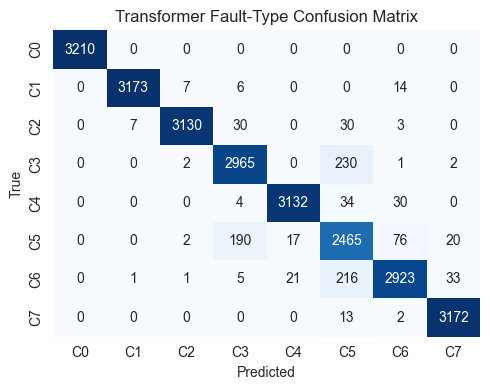

In [50]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Gather all predictions and true labels
all_preds_cls = []
all_true_cls = []

tst.eval()
with torch.no_grad():
    for x, y_cls, _ in test_loader:
        x = x.to(device)
        logits, _ = tst(x)
        preds = logits.argmax(dim=1)
        all_preds_cls.extend(preds.cpu().tolist())
        all_true_cls.extend(y_cls.tolist())

# Compute metrics
cm = confusion_matrix(all_true_cls, all_preds_cls)
report = classification_report(all_true_cls, all_preds_cls, digits=3)
print(report)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=[f'C{i}' for i in range(cm.shape[0])],
    yticklabels=[f'C{i}' for i in range(cm.shape[0])]
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Transformer Fault-Type Confusion Matrix')
plt.tight_layout()
plt.show()


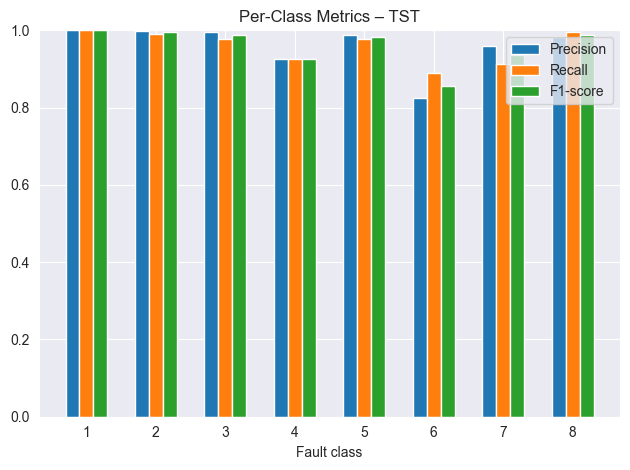

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support


# bar chart of precision, recall, F1
prec, rec, f1, _ = precision_recall_fscore_support(all_true_cls, all_preds_cls, zero_division=0)
x = np.arange(n_fault_classes)

plt.figure()
plt.bar(x-0.2, prec, width=0.2, label='Precision')
plt.bar(x,     rec,  width=0.2, label='Recall')
plt.bar(x+0.2, f1,   width=0.2, label='F1-score')
plt.xticks(x, x+1)
plt.xlabel('Fault class')
plt.ylim(0, 1)
plt.title('Per-Class Metrics – TST')
plt.legend()
plt.tight_layout()
plt.show()


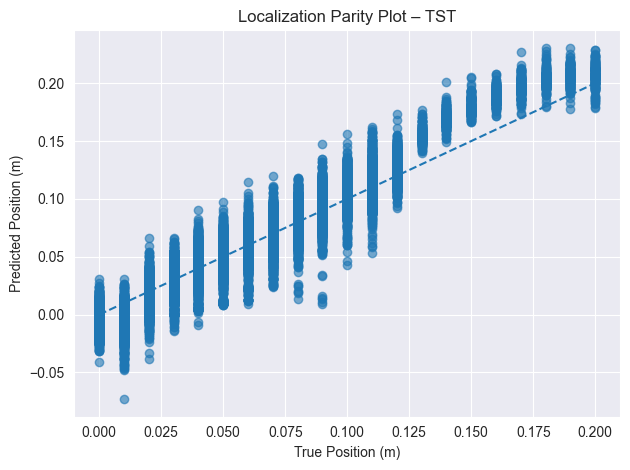

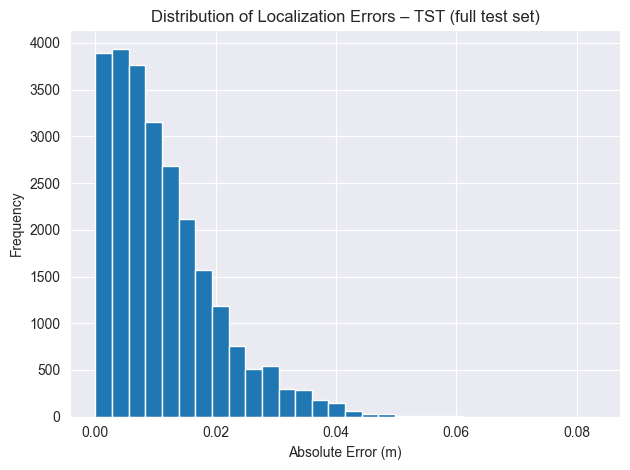

Localization RMSE on full test set: 0.014 m


In [52]:
import torch, matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seq_len = X_test_tensor.shape[1]          # 31
n_classes = 8                             # healthy + 7 faults
tst = TimeSeriesTransformer(seq_len=seq_len,
                            d_model=128,
                            n_heads=4,
                            n_layers=4,
                            dim_feedforward=256,
                            dropout=0.1,
                            n_classes=n_classes).to(device)
tst.load_state_dict(torch.load('models/best_tst.pt', map_location=device, weights_only=True))
tst.eval()

# 2) Forward-pass on the full test set
test_loader = DataLoader(TensorDataset(X_test_tensor,
                                       y_pos_test_tensor.squeeze(-1)),
                         batch_size=256)

pos_pred, y_pos_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        _, p_hat = tst(xb)               # p_hat shape: (B,)
        pos_pred.append(p_hat.cpu())
        y_pos_true.append(yb)

pos_pred   = torch.cat(pos_pred)
y_pos_true = torch.cat(y_pos_true)

# Parity plot
plt.figure()
plt.scatter(y_pos_true, pos_pred, alpha=0.6)
lims = [float(y_pos_true.min()), float(y_pos_true.max())]
plt.plot(lims, lims, linestyle='--')
plt.xlabel('True Position (m)')
plt.ylabel('Predicted Position (m)')
plt.title('Localization Parity Plot – TST')
plt.tight_layout()
plt.show()

# Histogram of absolute errors
abs_err = (pos_pred - y_pos_true).abs()

plt.figure()
plt.hist(abs_err.numpy(), bins=30)
plt.xlabel('Absolute Error (m)')
plt.ylabel('Frequency')
plt.title('Distribution of Localization Errors – TST (full test set)')
plt.tight_layout()
plt.show()

tst_rmse = float(torch.sqrt((abs_err ** 2).mean()))
print(f'Localization RMSE on full test set: {tst_rmse:.3f} m')


### Full Pipeline (GRU-AE to TST):

In [53]:
def gru_ae_detect(tensor, batch_size=64, threshold=0.1):
    if isinstance(tensor, np.ndarray):
        tensor = torch.from_numpy(tensor).float()

    errs = []
    with torch.no_grad():
        for i in range(0, tensor.shape[0], batch_size):
            x = tensor[i:i+batch_size].unsqueeze(1).to(device)
            recon = ae(x)
            # reconstruction error
            err = torch.mean((x - recon) ** 2, dim=(1, 2))
            errs.append(err)

    errs = torch.cat(errs)
    return errs > threshold          # boolean mask

anomaly_mask = gru_ae_detect(X_test, threshold=threshold)
fault_idx = anomaly_mask.nonzero(as_tuple=True)[0]

print(f"Detected {fault_idx.numel()} anomalies out of {X_test.shape[0]} test traces "
      f"({fault_idx.numel() / X_test.shape[0]:.1%}).")

Detected 21529 anomalies out of 25167 test traces (85.5%).


In [54]:
tst.load_state_dict(torch.load('models/best_tst.pt', map_location=device, weights_only=True))
tst.eval()
fault_idx = fault_idx.cpu()
X_fault = X_test_tensor[fault_idx]
y_class_fault = y_class_test_tensor[fault_idx]
y_pos_fault = y_pos_test_tensor[fault_idx]


fault_loader = DataLoader(TensorDataset(X_fault, y_class_fault, y_pos_fault),
                          batch_size=256)

In [55]:
logits_all, pos_pred_all = [], []
with torch.no_grad():
    for xb, _, _ in fault_loader:
        preds_cls, preds_pos = tst(xb.to(device))
        logits_all.append(preds_cls.cpu())
        pos_pred_all.append(preds_pos.cpu())

y_pred_cls = torch.cat(logits_all).argmax(1)
y_true_cls = y_class_fault
pos_pred   = torch.cat(pos_pred_all)


Visualising the Transformer model's performance:

In [56]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
print(classification_report(y_true_cls,
                            y_pred_cls,
                            digits=3,
                            target_names=[f'Class {i}' for i in range(0, int(y_true_cls.max()+1))]))

              precision    recall  f1-score   support

     Class 0      1.000     1.000     1.000       569
     Class 1      0.997     0.992     0.995      3069
     Class 2      0.996     0.979     0.987      2905
     Class 3      0.926     0.925     0.925      3011
     Class 4      0.989     0.979     0.984      3040
     Class 5      0.831     0.891     0.860      2693
     Class 6      0.962     0.919     0.940      3130
     Class 7      0.983     0.996     0.989      3112

    accuracy                          0.957     21529
   macro avg      0.960     0.960     0.960     21529
weighted avg      0.958     0.957     0.957     21529



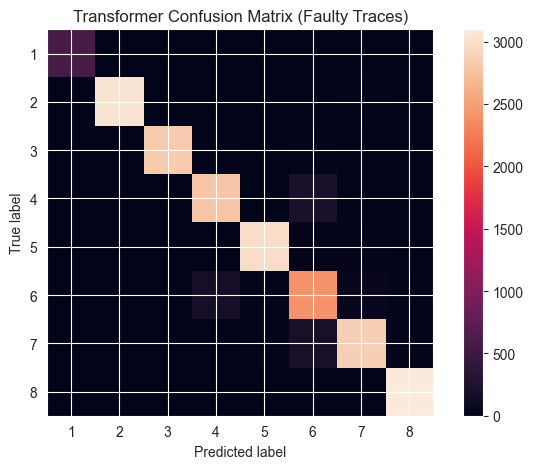

In [57]:
cm = confusion_matrix(y_true_cls, y_pred_cls)
n_fault_classes = cm.shape[0]

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Transformer Confusion Matrix (Faulty Traces)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.colorbar()
tick = np.arange(n_fault_classes)
plt.xticks(tick, tick+1)
plt.yticks(tick, tick+1)
plt.tight_layout()
plt.show()

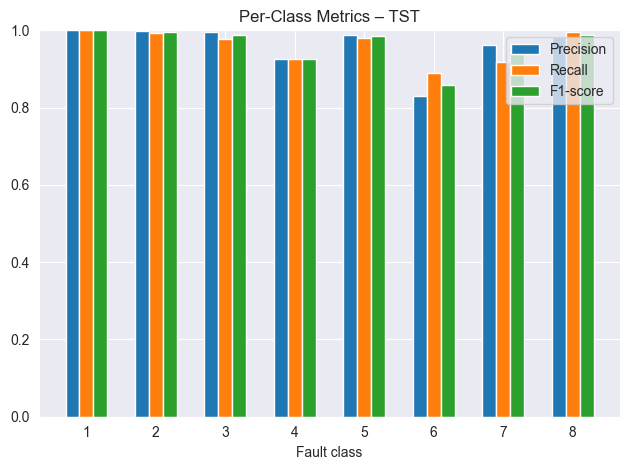

In [58]:
# bar chart of precision, recall, F1
prec, rec, f1, _ = precision_recall_fscore_support(y_true_cls, y_pred_cls, zero_division=0)
x = np.arange(n_fault_classes)

plt.figure()
plt.bar(x-0.2, prec, width=0.2, label='Precision')
plt.bar(x,     rec,  width=0.2, label='Recall')
plt.bar(x+0.2, f1,   width=0.2, label='F1-score')
plt.xticks(x, x+1)
plt.xlabel('Fault class')
plt.ylim(0, 1)
plt.title('Per-Class Metrics – TST')
plt.legend()
plt.tight_layout()
plt.show()


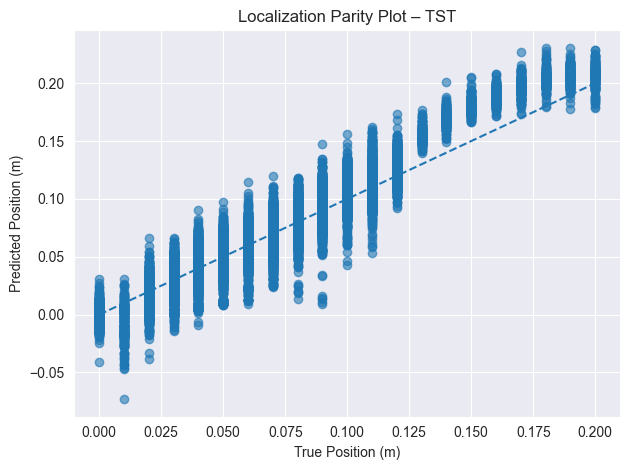

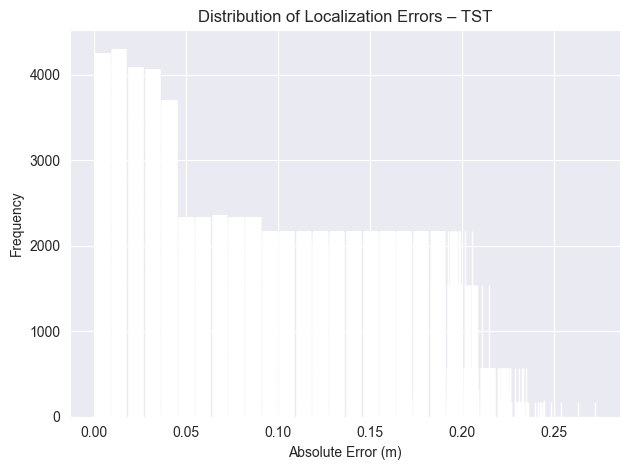

Localization RMSE on detected faults: 0.061 m


In [59]:
# Parity plot
plt.figure()
plt.scatter(y_pos_fault, pos_pred, alpha=0.6)
lims = [float(y_pos_fault.min()), float(y_pos_fault.max())]
plt.plot(lims, lims, linestyle='--')
plt.xlabel('True Position (m)')
plt.ylabel('Predicted Position (m)')
plt.title('Localization Parity Plot – TST')
plt.tight_layout()
plt.show()

# Histogram of absolute errors
abs_err = (pos_pred - y_pos_fault).abs()

plt.figure()
plt.hist(abs_err.numpy(), bins=30)
plt.xlabel('Absolute Error (m)')
plt.ylabel('Frequency')
plt.title('Distribution of Localization Errors – TST')
plt.tight_layout()
plt.show()

rmse = float(torch.sqrt((abs_err**2).mean()))
print(f'Localization RMSE on detected faults: {rmse:.3f} m')


In [60]:
def reconstruction_errors(batch_X, bs=256):
    ae.eval()
    errs = []
    with torch.no_grad():
        for i in range(0, batch_X.size(0), bs):
            chunk = batch_X[i:i+bs]
            x = chunk.unsqueeze(1).to(device)               # (B,1,feat_dim)
            recon = ae(x)
            mse   = (recon - x).pow(2).mean(dim=(1, 2))

            errs.append(mse.cpu())

    return torch.cat(errs)

def detect(batch_X, thresh=threshold):
    return reconstruction_errors(batch_X) > thresh

# Ground-truth vs detected faults
NORMAL_LABEL = 0

gt_fault_mask = (y_class_test_tensor != NORMAL_LABEL)
n_gt_faults   = gt_fault_mask.sum().item()
print(f"Ground-truth faults in test set : {n_gt_faults}")

ae_detect_mask = detect(X_test_tensor)
n_detected     = ae_detect_mask.sum().item()
print(f"Faults flagged by GRU-AE       : {n_detected}")

tp = (gt_fault_mask & ae_detect_mask).sum().item()
fp = (~gt_fault_mask & ae_detect_mask).sum().item()
fn = (gt_fault_mask & ~ae_detect_mask).sum().item()

print(f"TP = {tp}  |  FP = {fp}  |  FN = {fn}")

Ground-truth faults in test set : 21957
Faults flagged by GRU-AE       : 21533
TP = 20983  |  FP = 550  |  FN = 974


Fault Position RMSE on detected faults only for TCN and TST:

In [61]:
import numpy as np
from sklearn.metrics import mean_squared_error

fault_mask_np = (y_pos_test_tensor.squeeze().cpu().numpy() > 0)

true_pos_tcn = all_true_loc[fault_mask_np]
pred_pos_tcn = all_preds_loc[fault_mask_np]

rmse_tcn = np.sqrt(mean_squared_error(true_pos_tcn, pred_pos_tcn))
print(f'TCN RMSE on faults only : {rmse_tcn:.3f} m')
print(f'TST RMSE on faults only : {tst_rmse:.3f} m') # already calculated before

TCN RMSE on faults only : 0.048 m
TST RMSE on faults only : 0.014 m


## SHAP Analysis on TCN

In [62]:
import numpy as np
import torch.nn as nn
import shap

print("SHAP version:", shap.__version__)          # 0.48.0 expected

SHAP version: 0.48.0


In [63]:
RNG_SEED, BG_SIZE, EXP_SIZE = 0, 256, 128
rng = np.random.default_rng(RNG_SEED)
bg_idx  = rng.choice(len(X_train_tensor), BG_SIZE, replace=False)
exp_idx = rng.choice(len(X_test_tensor),  EXP_SIZE, replace=False)

background = X_train_tensor[bg_idx].cpu()   # (BG, 31)
X_exp      = X_test_tensor[exp_idx].cpu()   # (EXP, 31)
N_EXP, N_FEAT = X_exp.shape

In [64]:
#  frozen wrappers around the  TCN
class TCNClassifier(nn.Module):
    def __init__(self, core):
        super().__init__(); self.core = core.eval().cpu()
        for p in self.core.parameters(): p.requires_grad_(False)
    def forward(self, x):                                # x: (B, 31)
        return self.core(x.unsqueeze(1))[0]              # logits (B, C)

class TCNRegressor(nn.Module):
    def __init__(self, core):
        super().__init__(); self.core = core.eval().cpu()
        for p in self.core.parameters(): p.requires_grad_(False)
    def forward(self, x):
        return self.core(x.unsqueeze(1))[1].unsqueeze(1) # (B, 1)

wrap_cls = TCNClassifier(tcn)
wrap_loc = TCNRegressor(tcn)

N_CLASSES = wrap_cls(background[:1]).shape[1]
print(f"Detected {N_CLASSES} fault classes")

class_names = [f"Fault {i}" for i in range(N_CLASSES)]

Detected 8 fault classes


In [65]:
# SHAP explainers
expl_cls = shap.GradientExplainer(wrap_cls, background, batch_size=64)
expl_loc = shap.GradientExplainer(wrap_loc, background, batch_size=64)

raw_cls = expl_cls.shap_values(
    X_exp,
    ranked_outputs=N_CLASSES,       # int, not list
    output_rank_order="max"
)
raw_loc = expl_loc.shap_values(X_exp)

In [66]:
# 3. unwrap tuple for just the SHAP values
if isinstance(raw_cls, tuple):           # (phi, idx)
    raw_cls = raw_cls[0]
if isinstance(raw_loc, tuple):
    raw_loc = raw_loc[0]

In [67]:
# helper function to fix formatting because i can not figure out what format is going where
def to_list_per_class(vals, n_cls, n_exp, n_feat):
    if isinstance(vals, list) and len(vals) == n_cls:
        return [v[:, :n_feat] for v in vals]

    if isinstance(vals, list) and len(vals) == n_exp:
        a0 = vals[0]
        if a0.shape[0] == n_cls:                      # (C, F′)
            stacked = np.stack(vals, axis=1)          # (C, N, F′)
            return [stacked[i, :, :n_feat] for i in range(n_cls)]
        if a0.shape[-1] == n_cls:                     # (F′, C)
            stacked = np.stack(vals, axis=0)          # (N, F′, C)
            return [stacked[:, :n_feat, i] for i in range(n_cls)]

    if isinstance(vals, np.ndarray) and vals.ndim == 3:
        C, N, F = vals.shape
        # (C, N, F′)
        if C == n_cls and N == n_exp:
            return [vals[i, :, :n_feat] for i in range(n_cls)]
        # (N, C, F′)
        if vals.shape[0] == n_exp and vals.shape[1] == n_cls:
            return [vals[:, i, :n_feat] for i in range(n_cls)]
        # (N, F′, C)
        if vals.shape[0] == n_exp and vals.shape[2] == n_cls:
            return [vals[:, :n_feat, i] for i in range(n_cls)]

    raise RuntimeError(f"Unrecognised SHAP φ format → type: {type(vals)}, "
                       f"shape: {np.shape(vals)}")


cls_vals = to_list_per_class(raw_cls, N_CLASSES, N_EXP, N_FEAT)

# Pad any missing class with zeros
while len(cls_vals) < N_CLASSES:
    cls_vals.append(np.zeros((N_EXP, N_FEAT), dtype=np.float32))

In [68]:
if isinstance(raw_loc, list):
    loc_vals = raw_loc[0]
else:
    loc_vals = raw_loc

loc_vals = loc_vals.reshape(N_EXP, N_FEAT)

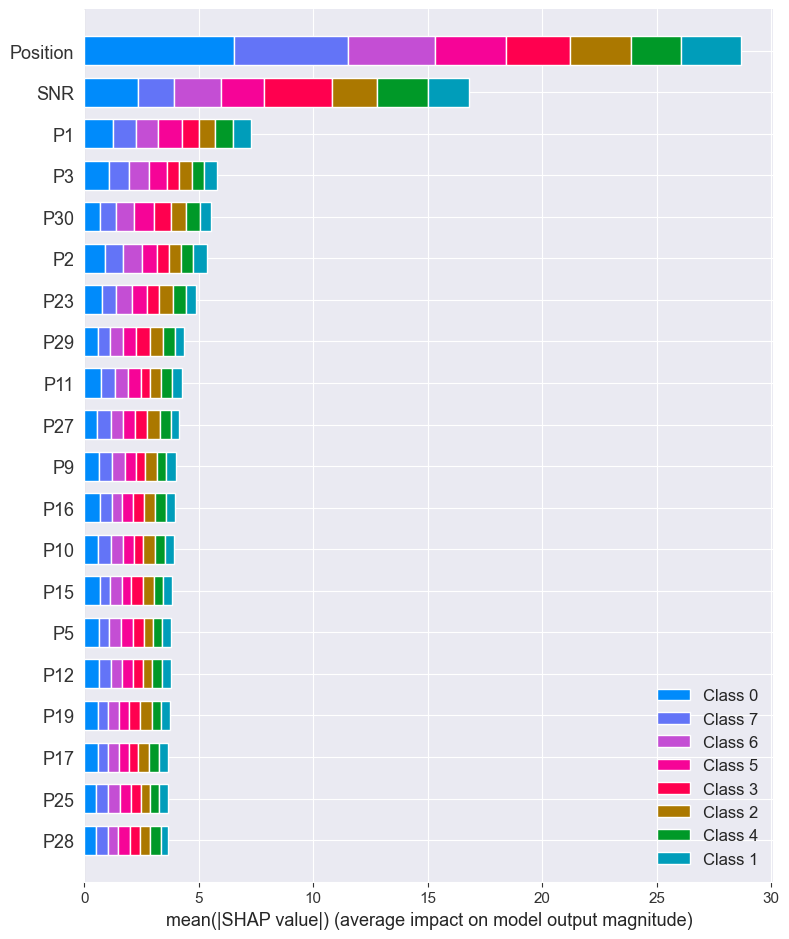

In [69]:
shap.summary_plot(
    cls_vals,
    X_exp.numpy(),
    feature_names=measurement_cols,
    class_names=[f"Class {i}" for i in range(N_CLASSES)],
    show=True
)

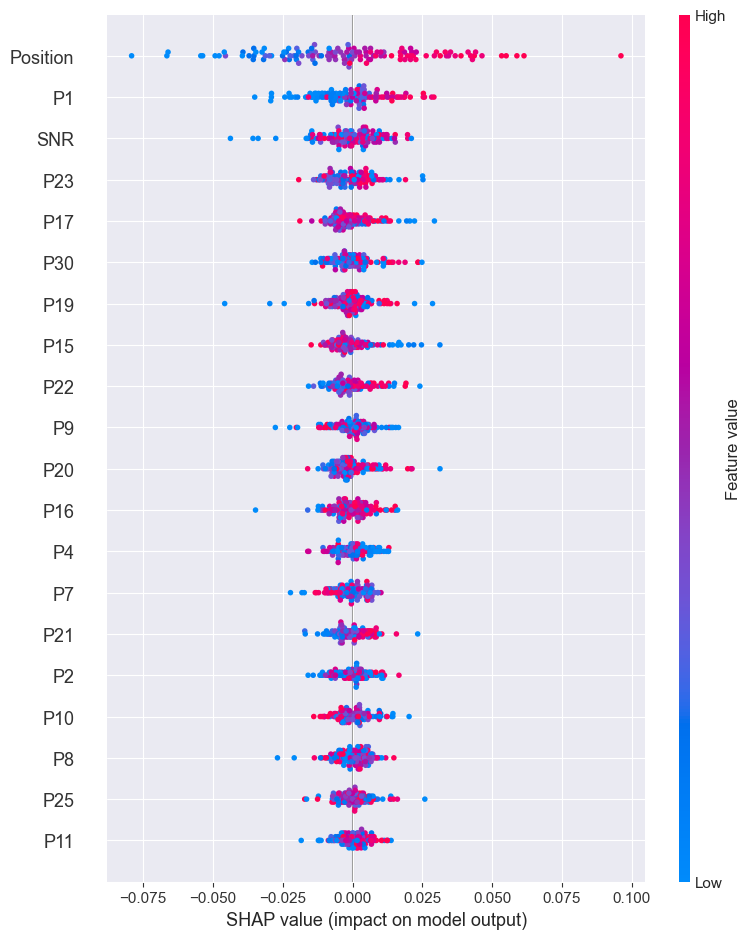

In [70]:
shap.summary_plot(
    loc_vals,
    X_exp.numpy(),
    feature_names=measurement_cols,
    show=True
)

### LLM (ChatGPT o3 model) explanation of SHAP plot:

The SHAP summary indicates that the regressed “Position” feature dominates the TCN’s decision-making. Samples taken from larger fibre distances consistently push the logits of certain fault classes upward, whereas small distances pull them down, showing that the network first forms a geographical prior about where a fault is likely to occur before scrutinising the fine-grained waveform. Signal-to-noise ratio emerges as the second most influential variable: high-SNR traces drive the model toward stronger, more confident predictions, while low-SNR measurements dampen the logits across classes. This monotonic relationship between SNR and SHAP value suggests that the network behaves sceptically under noisy conditions, in line with domain expectations.

Beyond these two global cues, the model concentrates on the leading and trailing edges of the 31-sample window. Elevated SHAP values on the first three amplitude channels reveal that reflections near the launch connector are highly diagnostic, particularly for fault types characterised by abrupt impedance mismatches close to the origin. Conversely, channels P27 through P30, which capture the tail-end of the trace, exert comparable influence but often with the opposite sign; cuts or high-loss splices near the remote end distort this region, and the network exploits that pattern to disambiguate classes. Mid-window samples provide supplementary evidence whose contributions fluctuate around zero, implying that they refine rather than drive the classification once distance, SNR and edge features have narrowed the hypothesis space.

The averaged SHAP magnitudes disaggregated by class show that Position and SNR are universally important: every class bar is almost fully painted in multi-coloured segments that span all fault categories, indicating no single class monopolises these features. Edge channels, however, weigh more heavily for classes distinguished by pronounced reflections—those segments visibly swell for such faults—while remaining moderate for classes defined by gradual attenuation. This balanced yet interpretable allocation of importance supports the view that the TCN has learned a physically plausible hierarchy: a coarse localisation prior modulated by trace quality, followed by inspection of reflection signatures at both ends and finally a context-dependent reading of intermediate samples. In operational terms, if the deployment environment shifts—say, new fibre spools introduce faults at previously unseen distances or the acquisition window is repositioned—the model may need recalibration, because its strongest inferences spring from spatial and edge-related cues. Nevertheless, its noise-aware behaviour affords a useful safeguard: in adverse SNR conditions the network naturally tempers its confidence, reducing the risk of spurious alarms.
